# News spreading on youtube from US Channels


## Table of Contents
* [1 Preprocessing and data filtering](#filter_data)
    * [1.1 Filter for Category 'News & Politics'](#filter_data-category)
    * [1.2 Filter for Active Channels](#filter_data-active)
    * [1.3 Get country of channel](#filter_data-country)
    * [1.4 Get if channel is english-speaking](#filter_data-english)
    * [1.5 Filter for language and country and save final data](#filter_data-save)
        * [1.5.1 Filtering relevant comments](#filter_data-comments)
* [2 How US News report on different events](#status_quo)
    * [2.1 Get relevant videos per event](#status_quo-videos_per_event)
    * [2.2 Extract video and channel features](#status_quo-features)
    * [2.3 Results and Comparison between Events](#status_quo-results)
* [3 How does the public response to events](#public_response)
    * [3.1 Compute Public Response Metrics](#public_response-metrics)
    * [3.2 Compute Correlation between Video Features and Response Metrics](#public_response-correlation)
    * [3.3 Compute F- and T-tests](#public_response-ttest)
* [4 Conclusion](#conclusion)

**Global imports**

In [1]:
import pandas as pd
import numpy as np
import polars as pl
from matplotlib import pyplot as plt

from src.scripts import filters
from src.utils import analysis_tools

**Path definitions**

In [2]:
path_df_channels_en = 'data/df_channels_en.tsv'
# TODO: not used yet path_df_channels_filtered = 'data/filtered_df_channels_en.csv'

path_df_timeseries = 'data/df_timeseries_en.tsv'

path_yt_metadata_feather = 'data/yt_metadata_helper.feather'
path_yt_metadata_feather_filtered = 'data/filtered_yt_metadata_helper.feather.csv'

path_yt_metadata = 'data/yt_metadata_en.jsonl'
path_yt_metadata_filtered = 'data/filtered_yt_metadata.csv'

path_final_channels = 'data/final_channels.csv'
path_final_timeseries = 'data/final_timeseries.csv'
path_final_yt_metadata_feather = 'data/final_yt_metadata_helper.csv'
path_final_yt_metadata = 'data/final_yt_metadata.csv'

## 1 Preprocessing and data filtering  <a class="anchor" id="filter_data"></a>



### 1.1 Filter for Category 'News & Politics' <a class="anchor" id="filter_data-category"></a>

In [3]:
pl_df_f = pl.read_csv(path_df_channels_en, separator="\t")

filtered_df_ch = filters.filter_df(pl_df_f, column_name="category_cc", 
                                   value="News & Politics", cmpstr="==")

print(f"Number of channels in category 'News & Politics': {len(filtered_df_ch)}")

Number of channels in category 'News & Politics': 2263


### 1.2 Filter for Active Channels <a class="anchor" id="filter_data-active"></a>

In [4]:
df_timeseries = pl.read_csv(path_df_timeseries, separator="\t")

filtered_df_timeseries = filters.filter_df_isin(df_timeseries, column_name="channel", 
                                                values=filtered_df_ch["channel"]) #.write_csv("../Youniverse/filtered_df_timeseries_en.tsv", include_header=True, separator="\t")

In [6]:
grouped_df = filtered_df_timeseries.group_by('channel').agg(pl.col('activity').mean().alias('mean_activity'))


#### Test activity filter

We try to find a threshold by looking at the plot.

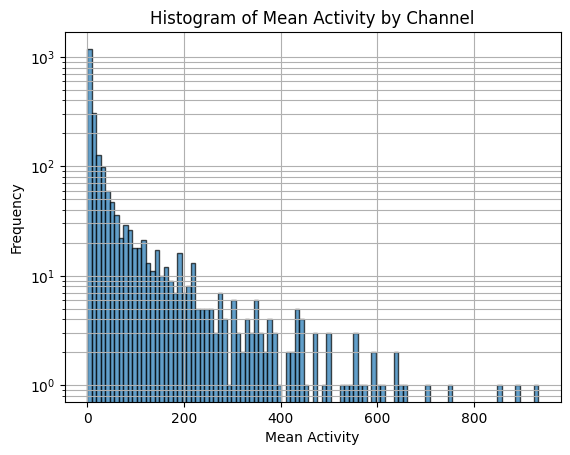

In [10]:
mean_activities = grouped_df['mean_activity'].to_list()

# Plot histogram of the mean activity values
plt.hist(mean_activities, bins=100, edgecolor="black", alpha=0.7)
plt.xlabel('Mean Activity')
plt.ylabel('Frequency')
plt.title('Histogram of Mean Activity by Channel')
# plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both")
plt.show()

Not real cluster. So we choose reasonable activity as threshold (verifies manually) as 4 videos per day.

#### filter channels by activity

In [ ]:
# merge with channels dataframe
filtered_df_ch = filtered_df_ch.join(grouped_df, on="channel", how="inner")

filtered_df_ch = filters.filter_df(filtered_df_ch, "mean_activity", 56, ">")

# filtered_df_ch.sort(by="mean_activity", descending=True).head(10)

print("Number of channels in category 'News & Politics' with more than 4 videos per",\
      f"day: {len(filtered_df_ch)}")

Number of channels in category 'News & Politics' with more than 4 videos per day: 407


#### filter yt_metadata by channels obtained before

#### Transform feather into csv

In [4]:
df_vd_f = pd.read_feather(path_yt_metadata_feather)
# save to csv
df_vd_f.to_csv(path_yt_metadata_feather+".csv", sep="\t", index=False)

#### filter yt_metadata feather csv

In [12]:
filters.df_filter_csv_batched(path_yt_metadata_feather+".csv", path_yt_metadata_feather_filtered,
                              column_name="channel_id", values=filtered_df_ch["channel"],
                              filter_method="is_in")

#### Test if filtering worked

In [ ]:
filtered_df_metadata_feather = pl.read_csv(path_yt_metadata_feather_filtered)
# filtered_df_metadata_feather.sample(5)
print("Number of videos from channels of interest (CoI): "\
      f"{len(filtered_df_metadata_feather)}")

Number of videos from channels of interest (CoI): 6812344


#### filter yt_metadata.jsonl with channels obtained earlier

##### transform yt_metadata-en.jsonl into csv

In [9]:
filters.df_filter_jsonl_batched(path_yt_metadata, path_yt_metadata_filtered, 
                                column_name="channel_id", 
                                values=filtered_df_ch["channel"],
                                sep="\t", batch_size=500)

Empty DataFrame
Columns: [categories, channel_id, crawl_date, description, dislike_count, display_id, duration, like_count, tags, title, upload_date, view_count]
Index: []


### 1.3 Get country of channel <a class="anchor" id="filter_data-country"></a>

In [ ]:
from src.utils import general_utils

In [ ]:
high_activity_channels = filtered_df_ch.with_columns(
    pl.col("channel").map_elements(lambda channel_id:general_utils.get_channel_country(channel_id)).alias("Channel_country")
)

C:\Users\jeffr\AppData\Local\Temp\ipykernel_25620\2021680753.py:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  high_activity_channels = high_activity_channels.with_columns(


#### Example of filtered channel dataframe with country

In [ ]:
high_activity_channels.write_csv("data/high_activity_channels_with_country")
print(high_activity_channels.sample(10))


shape: (10, 10)
┌────────────┬───────────┬───────────┬───────────┬───┬───────────┬─────────┬───────────┬───────────┐
│ category_c ┆ join_date ┆ channel   ┆ name_cc   ┆ … ┆ subscribe ┆ weights ┆ mean_acti ┆ Channel_c │
│ c          ┆ ---       ┆ ---       ┆ ---       ┆   ┆ r_rank_sb ┆ ---     ┆ vity      ┆ ountry    │
│ ---        ┆ str       ┆ str       ┆ str       ┆   ┆ ---       ┆ f64     ┆ ---       ┆ ---       │
│ str        ┆           ┆           ┆           ┆   ┆ f64       ┆         ┆ f64       ┆ str       │
╞════════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═════════╪═══════════╪═══════════╡
│ News &     ┆ 2017-02-1 ┆ UCMYlXK0j ┆ 10News    ┆ … ┆ 520837.0  ┆ 9.63    ┆ 93.886179 ┆ US        │
│ Politics   ┆ 7         ┆ yerVnc3dm ┆ WTSP      ┆   ┆           ┆         ┆           ┆           │
│            ┆           ┆ z-vjCA    ┆           ┆   ┆           ┆         ┆           ┆           │
│ News &     ┆ 2011-07-0 ┆ UCczsYSRG ┆ Himalaya  ┆ … ┆ 32797.0   ┆ 3.2005  

### 1.4 Get if channel is english-speaking with CHATGPT LLM API <a class="anchor" id="filter_data-english"></a>

Task: Use `filtered_yt_metadata.csv` and `high_activity_channels_with_country.csv` to filter for english videos

Since the youtube metadata dataset contains videos that are not from english speaking channels, awe need to do further processing. We use the CHATGPT API to analyze 5 videos and descriptions and if any video is not classified as english, the channel is marked as non-english

In [ ]:
# Load the second dataset (with the list of channel IDs to compare against)
channels_df = pd.read_csv("data/high_activity_channels_with_country.csv") 
channel_ids = set(channels_df['channel'].unique())  
chunk_reader = pd.read_csv("data/filtered_yt_metadata.csv", chunksize=5000)

matching_videos = []
# Dictionary to track how many videos are saved for each channel
channel_video_count = {channel_id: 0 for channel_id in channel_ids}

for chunk in chunk_reader:
    # Filter rows where channel_id in chunk is in the set of channel_ids from channels_df
    matching_rows = chunk[chunk['channel_id'].isin(channel_ids)]
    for channel_id, group in matching_rows.groupby('channel_id'):
        # If we've already saved 5 videos for this channel, skip it
        if channel_video_count[channel_id] >= 5:
            continue
        # Get the first 5 videos for this channel (or fewer if there are less than 5)
        first_5_videos = group.head(5 - channel_video_count[channel_id])  # Adjust to avoid exceeding 5
        # Add the number of videos saved for this channel
        channel_video_count[channel_id] += len(first_5_videos)
        matching_videos.append(first_5_videos)

# Convert the list into DataFrame
final_df = pd.concat(matching_videos, ignore_index=True)
final_df.to_csv('data/matching_videos.csv', index=False)


#### Parsing the video title and description with CHATGPT API

In [42]:
## TESTING THE FUNCTION 

from src.utils import general_utils
import importlib

importlib.reload(general_utils) 
final_df = pd.read_csv("data/matching_videos.csv")
# videos = final_df.loc[final_df['channel_id'] == "UClMs26ViHFMy7MS897Alcxw"]
result = general_utils.check_channel_english(final_df, "UClMs26ViHFMy7MS897Alcxw")

channel is english


In [ ]:
# Iterate through pandas dataframe and check if channel is english
# Check each channel and store results
high_activity_channels = high_activity_channels.with_columns(
    pl.col("channel").map_elements(lambda channel_id:general_utils.check_channel_english(final_df, channel_id)).alias("Is_English")
)

In [ ]:
high_activity_channels.write_csv("data/high_activity_channels_country_and_english.csv")

#### Printing value counts for which country channels that speak english and do not speak english are

In [ ]:
filtered = pd.read_csv("data/high_activity_channels_country_and_english.csv")

In [17]:
# filtered["Is_English"].value_counts()
english = filtered[filtered["Is_English"] == True]
print(len(english))
print("english")
print(english["Channel_country"].value_counts())

not_english = filtered[filtered["Is_English"] == False]
print("not_english")
print(not_english["Channel_country"].value_counts())

278
english
Channel_country
US                   149
IN                    49
PK                    13
Channel not found      9
CA                     8
GB                     7
NG                     6
ZA                     4
KE                     4
PH                     3
CN                     3
FR                     2
GH                     2
IL                     2
MY                     2
QA                     1
UK                     1
CH                     1
UG                     1
BZ                     1
TR                     1
DE                     1
EC                     1
BD                     1
GU                     1
PG                     1
AU                     1
LK                     1
SG                     1
TH                     1
Name: count, dtype: int64
not_english
Channel_country
IN                   81
PK                   11
US                   10
Channel not found     6
PH                    5
NP                    4
BD                    3


### 1.5 Filter for language and country and save all the final dataframes <a class="anchor" id="filter_data-save"></a>

In [ ]:
df_final_channels = pl.read_csv("data/high_activity_channels_country_and_english.csv", separator=",")
df_final_channels = df_final_channels.filter((pl.col("Channel_country") == "US") & (pl.col("Is_English") == True))
df_final_channels = df_final_channels.rename({"Is_English": "is_english", "Channel_country": "channel_country"})

df_final_channels.write_csv(path_final_channels, include_header=True, separator=",")

In [ ]:
# metadata feather
filters.df_filter_csv_batched(path_yt_metadata_feather_filtered, path_final_yt_metadata_feather,
                              column_name="channel_id", values=df_final_channels["channel"],
                              filter_method="is_in", sep_in="\t", sep_out=",")

In [ ]:
# metadata
df_final_yt_metadata = pl.read_csv(path_yt_metadata_filtered, has_header=True, 
                                   separator="\t", infer_schema=False)
df_final_yt_metadata = filters.filter_df_isin(df_final_yt_metadata, "channel_id", df_final_channels["channel"])
df_final_yt_metadata.write_csv(path_final_yt_metadata, include_header=True, separator=",")


In [ ]:
# timeseries
df_final_timeseries = pl.read_csv(path_df_timeseries, separator="\t", has_header=True)
df_final_timeseries = filters.filter_df_isin(df_final_timeseries, column_name="channel", 
                                                values=df_final_channels["channel"])
df_final_timeseries.write_csv(path_final_timeseries, include_header=True, separator=",")


Summary of Filtering:

In [ ]:
print("Final Number of videos from channels of interest (CoI): "\
      f"{len(df_final_yt_metadata)}")

print("Final channels of interest (CoI): "\
      f"{len(df_final_channels)}")

Final Number of videos from channels of interest (CoI): 2548064
Final channels of interest (CoI): 149


#### 1.5.1 Filtering relevant comments <a class="anchor" id="filter_data-comments"></a> 

We want to filter out the comments related the videos in the df_final_yt_metadata. To do this, we initially tried using our personal PCs to filter out the youtube_comments.tsv.gz dataset, but found that it would take multiple months. To address this lack of resources, we use AWS resources for more powerful computations. The code below is running on Amazon Sagemaker and the dataset is stored in a S3 bucket.

In [ ]:
import boto3
import polars as pl
import pandas as pd
import s3fs
from urllib.parse import urlparse

In [ ]:
# Define the S3 bucket name and any prefix you want to use
bucket_name = 'adaproject-lil0mohammedali'

# Initialize a session using Boto3
s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)

for obj in bucket.objects.filter():
    print(obj.key)


In [ ]:
s3_feather_path = "s3://adaproject-lil0mohammedali/final_yt_metadata_helper.csv"
filtered_df_metadata_feather = pl.read_csv(s3_feather_path)
s3_comments_path = "s3://adaproject-lil0mohammedali/youtube_comments.tsv.gz"

# Initialize S3 filesystem
fs = s3fs.S3FileSystem()

# Define S3 path and batch size
s3_path = s3_comments_path
batch_size = 8600000000/100000
total_batches = 8600000000/batch_size

s3_output_path = 's3://adaproject-lil0mohammedali/filtered_youtube_comments.tsv'  # Output path in S3

i = 0
# Open the output file on S3 for writing
with fs.open(s3_output_path, "wb") as output_file:
    # Read the file in chunks directly from S3
    with fs.open(s3_path, "rb") as f:
        for chunk in pd.read_csv(f, sep='\t', compression='gzip', chunksize=batch_size):
            # Convert chunk to Polars DataFrame
            batch = pl.DataFrame(chunk)
            # Filter data based on video_id
            filtered_batch = batch.filter(pl.col("video_id").is_in(filtered_df_metadata_feather["display_id"])) 
            
            # For the first batch, include the header
            if i == 0:
                filtered_batch.write_csv(output_file, include_header=True)
            else:
                # For subsequent batches, append without the header
                filtered_batch.write_csv(output_file, include_header=False)
            
            i += 1
            print(f"batch {i} / {total_batches} \r", end='')

## 2 How US News report on different events <a class="anchor" id="status_quo"></a>

### 2.1 Get relevant videos per event <a class="anchor" id="status_quo-videos_per_event"></a>

TODO: USING JADS CODE AND PLOTS

### 2.2 Extract video and channel features<a class="anchor" id="status_quo-features"></a>

### 2.3 Results and Comparison between Events <a class="anchor" id="status_quo-results"></a>

USE PLOTS

## 3 How does the public response to events <a class="anchor" id="public_response"></a>

In [15]:
from src.utils.analysis_tools import *
channels_df = pl.read_csv(path_final_channels)
timeseries_df = pl.read_csv(path_final_timeseries)
video_metadata_df = pd.read_csv(path_final_yt_metadata)
video_feather_df = pl.read_csv(path_final_yt_metadata_feather)
num_comments = pl.read_csv('./data/num_comments.csv')

C:\Users\samue\AppData\Local\Temp\ipykernel_23496\1876350136.py:4: DtypeWarning: Columns (4,6,7,11) have mixed types. Specify dtype option on import or set low_memory=False.
  video_metadata_df = pd.read_csv(path_final_yt_metadata)


In [16]:
video_metadata_df['dislike_count'] = pd.to_numeric(video_metadata_df['dislike_count'], errors='coerce')
video_metadata_df['duration'] = pd.to_numeric(video_metadata_df['duration'], errors='coerce')
video_metadata_df['like_count'] = pd.to_numeric(video_metadata_df['like_count'], errors='coerce')
video_metadata_df['view_count'] = pd.to_numeric(video_metadata_df['view_count'], errors='coerce')
video_metadata_df = pl.DataFrame(video_metadata_df)
video_metadata_df = video_metadata_df.join(num_comments, on='display_id')

In [ ]:
#filter by date
min_date = pl.datetime(2018,1,1)
max_date = pl.datetime(2019,1,1)

filtered_df_timeseries = timeseries_df.with_columns(pl.col('datetime').str.to_datetime())
video_metadata_df = filtered_df_vidvideo_metadata_dffiltered_df_vid = video_metadata_df.filter((pl.col('upload_date') >= min_date) & (pl.col('upload_date') <= max_date))
channels_df = channels_df.filter(pl.col('channel_id').is_in(video_metadata_df['channel_id']))
filtered_num_comments = num_comments.filter(pl.col('display_id').is_in(video_metadata_df['display_id']))

In [17]:
#rename channel id columns to all have the same name
channels_df = channels_df.rename({'channel':'channel_id'})
timeseries_df = timeseries_df.rename({'channel':'channel_id'})

In [18]:
#create dictionnary to more easily navigate between channel name and channel id
channel_dict = dict(channels_df[['name_cc','channel_id']].iter_rows())
inv_channel_dict = {v: k for k, v in channel_dict.items()}

### 3.1 Compute Public Response Metrics <a class="anchor" id="public_response-metrics"></a>

In [19]:
#extract starting features from feather dataset
response_metrics = video_feather_df.drop(['categories','channel_id','upload_date', 'duration'])

#add a column for likes/dislikes ratio
response_metrics = response_metrics.with_columns((pl.col('like_count')/pl.col('dislike_count')).alias('Likes/Dislikes'))

#remove the entries with infinite like/dislike ratio, and set the NaNs to zero (NaN <=> likes/dislike = 0/0)
response_metrics = response_metrics.with_columns(pl.col('Likes/Dislikes').replace([np.inf,np.NaN], [np.inf, 0])).drop_nulls()
response_metrics = response_metrics.filter(~pl.col('Likes/Dislikes').is_infinite())

response_metrics

dislike_count,display_id,like_count,view_count,Likes/Dislikes
f64,str,f64,f64,f64
2.0,"""rbBK6syU-fY""",31.0,916.0,15.5
1.0,"""qUPXnZseiTc""",34.0,2521.0,34.0
1.0,"""vH2eJXtRLuk""",0.0,32.0,0.0
2.0,"""b_FLNDqVU4Q""",0.0,23.0,0.0
10.0,"""bftpnHrXhhY""",85.0,9532.0,8.5
…,…,…,…,…
0.0,"""OazawmzLCJQ""",0.0,53.0,0.0
0.0,"""RuiCB2jUHVw""",0.0,44.0,0.0
0.0,"""XU-phrdiMYQ""",0.0,1054.0,0.0


In [20]:
#add a column to account for capitalization ratio of th title
response_metrics = cap_ratio(video_metadata_df, 'title')

c:\Users\samue\Desktop\Box Sync\3.Samuel\Uni_24-25\ADA\ada-2024-project-lil0mohammadali\src\utils\analysis_tools.py:162: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  video_list = video_list.with_columns(


#### Replies to comments and number of comments

The number of comments per video is given in `final_num_comments.csv`, so no need to compute them. For average replies per comment per video, we can compute it using `final_yt_comments.csv`.

**Disclaimer**:
At this point of our project we have not yet filtered the comments for the videos we are interested in. Therefore we will only propose a pipeline for the computation of the metrics.

In [4]:
# load a sample comments dataset
path_final_comments = 'data/filtered_youtube_comments_example.tsv'

df_comments = pl.read_csv(path_final_comments, separator=",", has_header=True)

In [ ]:
replies_metrics = analysis_tools.comment_replies_metrics(df_comments)
response_metrics = response_metrics.join(replies_metrics, on="video_id", how="inner")
response_metrics

### 3.2 Compute Correlation between Video Features and Response Metrics <a class="anchor" id="public_response-correlation"></a>

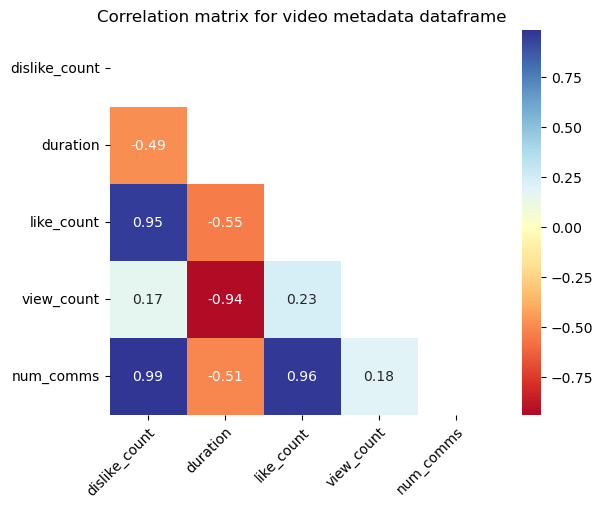

In [ ]:
#plot correlation between features in the video metadata dataframe
vid_corr = plot_correlation_matrix(video_metadata_df, 'Correlation matrix for video metadata dataframe')

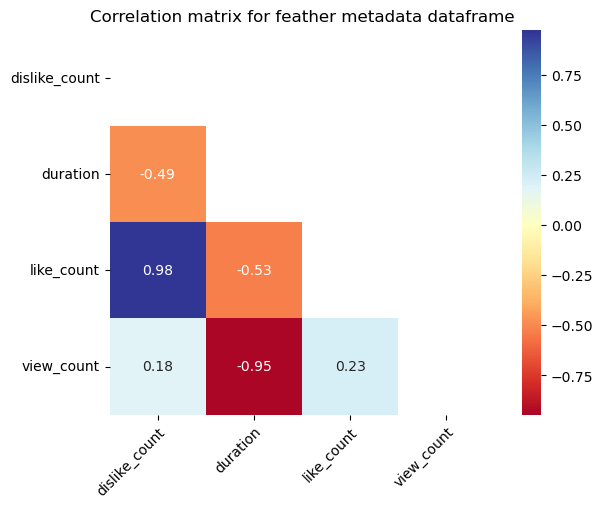

In [ ]:
#plot correlation between features in the video feather dataframe
feather_corr = plot_correlation_matrix(video_feather_df, 'Correlation matrix for feather metadata dataframe')

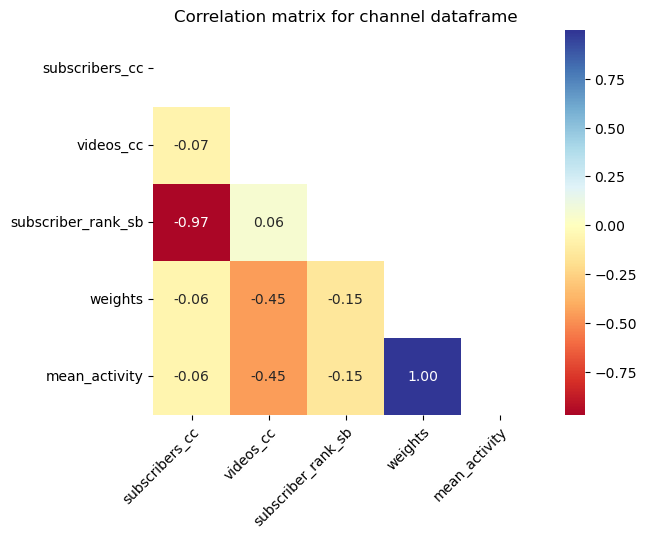

In [ ]:
#plot correlation between features in the channel dataframe
channel_corr = plot_correlation_matrix(channels_df, 'Correlation matrix for channel dataframe')

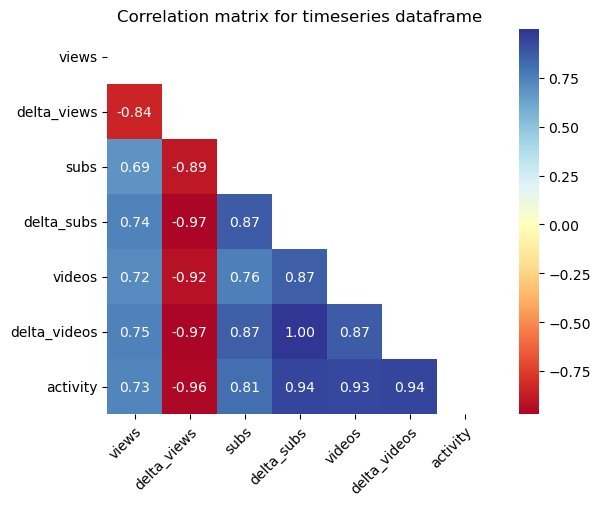

In [ ]:
#plot correlation between features in the timeseries dataframe
timeseries_corr = plot_correlation_matrix(timeseries_df, 'Correlation matrix for timeseries dataframe')

In [10]:
#select the first features from the video metadata
#channel_id and display_id are for merging other dataframes
vid_features = video_metadata_df[['display_id','channel_id','duration']]

In [11]:
#compute general statistics on the timeseries dataframe and add join them together
counts, means, stds, meds  = get_general_ch_statistics(timeseries_df,['delta_videos','subs'])
joined = counts.join(means, on='channel_id').rename({'delta_videos':'mean_delta_videos','subs':'mean_subs' })
joined = joined.join(stds, on='channel_id').rename({'delta_videos':'std_delta_videos','subs':'std_subs' })
joined = joined.join(meds, on='channel_id').rename({'delta_videos':'median_delta_videos','subs':'median_subs' })

In [12]:
#merge the timeseries statistics with the video features daframe
vid_features = vid_features.join(joined, on='channel_id')
vid_features = vid_features.drop('channel_id')

In [ ]:
#join the features and metric dataframes together
features_and_metrics = vid_features.join(response_metrics, on='display_id').drop_nulls()

c:\Users\samue\anaconda3\envs\adaenv\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


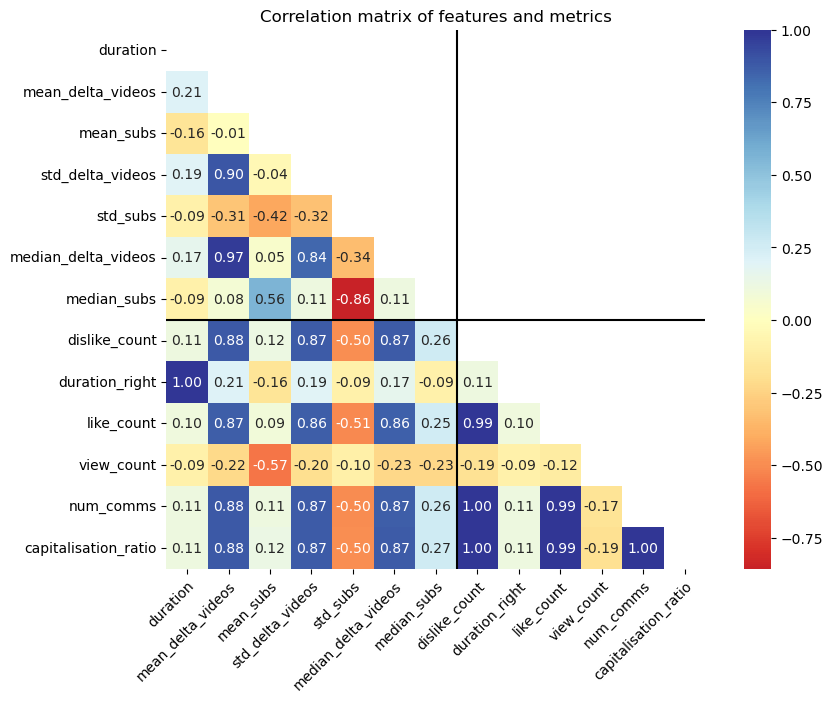

In [ ]:
corr = plot_correlation_matrix_features_and_metrics(features_and_metrics)

### 3.3 Compute F- and T-tests <a class="anchor" id="public_response-ttest"></a>

## 4 Conclusion <a class="anchor" id="conclusion"></a>